In [82]:
from sklearn.ensemble import GradientBoostingClassifier


import numpy as np
from matplotlib import pyplot as plt
import art#fully initialise module
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack


import warnings
warnings.filterwarnings('ignore')

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

data=pd.read_csv('dataset.csv')

# clean up column names

data.columns = data.columns.\
    str.strip().\
    str.lower()

#____remove non-numeric columns
    
data = data.select_dtypes(['number']) 


#__extracting dependent and independent variable

x=data.drop(['type'],axis=1)
y=data['type']
x=np.nan_to_num(x) #____replace nan with zero and inf with finite numbers

In [118]:
y

0       1
1       0
2       0
3       0
4       0
       ..
1776    1
1777    1
1778    0
1779    0
1780    0
Name: type, Length: 1781, dtype: int64

In [111]:
data.head()

,url_length,number_special_characters,content_length,tcp_conversation_exchange,dist_remote_tcp_port,remote_ips,app_bytes,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,app_packets,dns_query_times,type
0,16,7,263.0,7,0,2,700,9,10,1153,832,9,2.0,1
1,16,6,15087.0,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,16,6,324.0,0,0,0,0,0,0,0,0,0,0.0,0
3,17,6,162.0,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,17,6,124140.0,57,2,5,4278,61,62,129889,4586,61,4.0,0


In [84]:
#______Splitting the data into Training and test dataset
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=1/3,random_state=44)


# #_______Logistic Regression
# from sklearn.linear_model import LogisticRegression

# classifier=LogisticRegression(random_state=42)
# classifier.fit(x_train,y_train)

# pred2 = classifier.predict(x_test)


In [85]:
def get_adversarial_examples(x_train, y_train):
    
    # Create and fit GradientBoostingClassifier
    model = GradientBoostingClassifier()
    model.fit(X=x_train, y=y_train)

    # Create ART classifier for scikit-learn GradientBoostingClassifier
    art_classifier = SklearnClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    x_train_adv = zoo.generate(x_train)

    return x_train_adv, model

In [86]:
def get_data(num_classes):
    x_train, y_train = load_iris(return_X_y=True)
    x_train = x_train[y_train < num_classes][:, [0, 1]]
    y_train = y_train[y_train < num_classes]
    x_train[:, 0][y_train == 0] *= 2
    x_train[:, 1][y_train == 2] *= 2
    x_train[:, 0][y_train == 0] -= 3
    x_train[:, 1][y_train == 2] -= 2
    
    x_train[:, 0] = (x_train[:, 0] - 4) / (9 - 4)
    x_train[:, 1] = (x_train[:, 1] - 1) / (6 - 1)
    
    return x_train, y_train

In [87]:
def plot_results(model, x_train, y_train, x_train_adv, num_classes):
    
    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 5, 5))

    colors = ['orange', 'blue', 'green']

    for i_class in range(num_classes):

        # Plot difference vectors
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].plot([x_1_0, x_2_0], [x_1_1, x_2_1], c='black', zorder=1)

        # Plot benign samples
        for i_class_2 in range(num_classes):
            axs[i_class].scatter(x_train[y_train == i_class_2][:, 0], x_train[y_train == i_class_2][:, 1], s=20,
                                 zorder=2, c=colors[i_class_2])
        axs[i_class].set_aspect('equal', adjustable='box')

        # Show predicted probability as contour plot
        h = .01
        x_min, x_max = 0, 1
        y_min, y_max = 0, 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z_proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z_proba = Z_proba[:, i_class].reshape(xx.shape)
        im = axs[i_class].contourf(xx, yy, Z_proba, levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   vmin=0, vmax=1)
        if i_class == num_classes - 1:
            cax = fig.add_axes([0.95, 0.2, 0.025, 0.6])
            plt.colorbar(im, ax=axs[i_class], cax=cax)

        # Plot adversarial samples
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].scatter(x_2_0, x_2_1, zorder=2, c='red', marker='X')
        axs[i_class].set_xlim((x_min, x_max))
        axs[i_class].set_ylim((y_min, y_max))

        axs[i_class].set_title('class ' + str(i_class))
        axs[i_class].set_xlabel('feature 1')
        axs[i_class].set_ylabel('feature 2')

ZOO: 100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.44it/s]


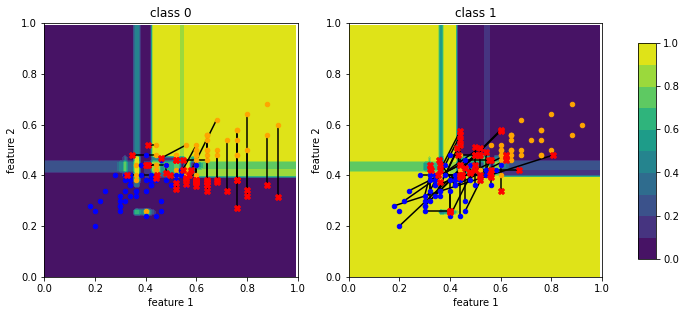

In [88]:
num_classes = 2
x_train, y_train = get_data(num_classes=num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train)
plot_results(model, x_train, y_train, x_train_adv, num_classes)

In [119]:
model = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, 
                                   criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                   min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                   verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto', 
                                   validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)

In [120]:
model.fit(X=x_train, y=y_train)

GradientBoostingClassifier(presort='auto')

In [91]:
art_classifier = SklearnClassifier(model=model)

In [92]:
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100,
                binary_search_steps=20, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.25)

In [93]:
x_train

array([[0.64, 0.5 ],
       [0.56, 0.4 ],
       [0.48, 0.44],
       [0.44, 0.42],
       [0.6 , 0.52],
       [0.76, 0.58],
       [0.44, 0.48],
       [0.6 , 0.48],
       [0.36, 0.38],
       [0.56, 0.42],
       [0.76, 0.54],
       [0.52, 0.48],
       [0.52, 0.4 ],
       [0.32, 0.4 ],
       [0.92, 0.6 ],
       [0.88, 0.68],
       [0.76, 0.58],
       [0.64, 0.5 ],
       [0.88, 0.56],
       [0.64, 0.56],
       [0.76, 0.48],
       [0.64, 0.54],
       [0.44, 0.52],
       [0.64, 0.46],
       [0.52, 0.48],
       [0.6 , 0.4 ],
       [0.6 , 0.48],
       [0.68, 0.5 ],
       [0.68, 0.48],
       [0.48, 0.44],
       [0.52, 0.42],
       [0.76, 0.48],
       [0.68, 0.62],
       [0.8 , 0.64],
       [0.56, 0.42],
       [0.6 , 0.44],
       [0.8 , 0.5 ],
       [0.56, 0.52],
       [0.36, 0.4 ],
       [0.64, 0.48],
       [0.6 , 0.5 ],
       [0.4 , 0.26],
       [0.36, 0.44],
       [0.6 , 0.5 ],
       [0.64, 0.56],
       [0.52, 0.4 ],
       [0.64, 0.56],
       [0.44,

In [109]:
x_test

array([[5.1000e+01, 1.0000e+01, 0.0000e+00, ..., 5.0930e+03, 4.1000e+01,
        6.0000e+00],
       [5.6000e+01, 9.0000e+00, 0.0000e+00, ..., 2.4160e+03, 2.1000e+01,
        6.0000e+00],
       [1.2800e+02, 2.5000e+01, 2.9840e+04, ..., 4.3200e+02, 4.0000e+00,
        0.0000e+00],
       ...,
       [4.9000e+01, 9.0000e+00, 1.6200e+02, ..., 2.1380e+03, 2.5000e+01,
        6.0000e+00],
       [4.8000e+01, 1.0000e+01, 3.4500e+02, ..., 1.4740e+03, 1.9000e+01,
        2.0000e+00],
       [6.5000e+01, 1.1000e+01, 1.2339e+04, ..., 1.9220e+03, 2.2000e+01,
        4.0000e+00]])

In [95]:
score = model.score(x_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 0.9600


In [125]:
x_train[0:1, :]

array([[0.64, 0.5 ]])

In [97]:
prediction = model.predict(x_train[0:1, :])[0]
print("Benign Training Predicted Label: %i" % prediction)

Benign Training Predicted Label: 0


In [98]:
score = model.score(x_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.0900


In [124]:
x_train_adv[0:1, :]

array([[0.64     , 0.3740269]])

In [99]:
prediction = model.predict(x_train_adv[0:1, :])[0]
print("Adversarial Training Predicted Label: %i" % prediction)

Adversarial Training Predicted Label: 1


In [101]:
x_test

array([[5.1000e+01, 1.0000e+01, 0.0000e+00, ..., 5.0930e+03, 4.1000e+01,
        6.0000e+00],
       [5.6000e+01, 9.0000e+00, 0.0000e+00, ..., 2.4160e+03, 2.1000e+01,
        6.0000e+00],
       [1.2800e+02, 2.5000e+01, 2.9840e+04, ..., 4.3200e+02, 4.0000e+00,
        0.0000e+00],
       ...,
       [4.9000e+01, 9.0000e+00, 1.6200e+02, ..., 2.1380e+03, 2.5000e+01,
        6.0000e+00],
       [4.8000e+01, 1.0000e+01, 3.4500e+02, ..., 1.4740e+03, 1.9000e+01,
        2.0000e+00],
       [6.5000e+01, 1.1000e+01, 1.2339e+04, ..., 1.9220e+03, 2.2000e+01,
        4.0000e+00]])

In [104]:
model.predict(x_test[0:1, :])

array([0, 0])

In [106]:
prediction = model.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 0
